In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
def graph_load_batch(data_dir,
                     # min_num_nodes=20,
                     # max_num_nodes=1000,
                     name='ENZYMES',
                     node_attributes=False,
                     graph_labels=True):
    '''
    load many graphs, e.g. enzymes
    :return: a list of graphs
    '''
    print('Loading graph dataset: ' + str(name))
    G = nx.Graph()
    # load data
    path = os.path.join(data_dir, name.upper())

    print(os.path.join(path, '{}_A.txt'.format(name)))

    data_adj = np.loadtxt(
        os.path.join(path, '{}_A.txt'.format(name)), delimiter=',').astype(int)
    
    print("Loaded Adjacency")
    if node_attributes:
        data_node_att = np.loadtxt(
            os.path.join(path, '{}_node_attributes.txt'.format(name)),
            delimiter=',')
    data_node_label = np.loadtxt(
        os.path.join(path, '{}_node_labels.txt'.format(name)),
        delimiter=',').astype(int)
    data_graph_indicator = np.loadtxt(
        os.path.join(path, '{}_graph_indicator.txt'.format(name)),
        delimiter=',').astype(int)
    if graph_labels:
        data_graph_labels = np.loadtxt(
            os.path.join(path, '{}_graph_labels.txt'.format(name)),
            delimiter=',').astype(int)

    data_tuple = list(map(tuple, data_adj))
    # print(len(data_tuple))
    # print(data_tuple[0])

    # add edges
    G.add_edges_from(data_tuple)
    # add node attributes
    for i in range(data_node_label.shape[0]):
        if node_attributes:
            G.add_node(i + 1, feature=data_node_att[i])
        G.add_node(i + 1, label=data_node_label[i])
    G.remove_nodes_from(list(nx.isolates(G)))

    # remove self-loop
    G.remove_edges_from(nx.selfloop_edges(G))

    # print(G.number_of_nodes())
    # print(G.number_of_edges())

    # split into graphs
    graph_num = data_graph_indicator.max()
    node_list = np.arange(data_graph_indicator.shape[0]) + 1
    graphs = []
    max_nodes = 0
    min_nodes = int(1e6)
    for i in tqdm(range(graph_num)):
        # find the nodes for each graph
        nodes = node_list[data_graph_indicator == i + 1]
        G_sub = G.subgraph(nodes)
        if graph_labels:
            G_sub.graph['label'] = data_graph_labels[i]
        # print('nodes', G_sub.number_of_nodes())
        # print('edges', G_sub.number_of_edges())
        # print('label', G_sub.graph)
        # if G_sub.number_of_nodes() >= min_num_nodes and G_sub.number_of_nodes(
        
        Gcc = sorted(nx.connected_components(G_sub), key=len, reverse=True)
        G0 = G_sub.subgraph(Gcc[0])
        
        # ) <= max_num_nodes:
        graphs.append(G0)
    if G_sub.number_of_nodes() > max_nodes:
        max_nodes = G_sub.number_of_nodes()
    elif G_sub.number_of_nodes() < min_nodes:
        min_nodes = G_sub.number_of_nodes()
      # print(G_sub.number_of_nodes(), 'i', i)
      # print('Graph dataset name: {}, total graph num: {}'.format(name, len(graphs)))
      # logging.warning('Graphs loaded, total num: {}'.format(len(graphs)))
    print('Loaded')
    return graphs    #, max_nodes, min_nodes

In [3]:
data_dir = "/home/alex/Projects/GRAN_social/data"

facebook_graphs = graph_load_batch(data_dir, name = "FB_LARGE")
git_graphs      = graph_load_batch(data_dir, name = "GIT")
twitch_graphs   = graph_load_batch(data_dir, name = "TWITCH")
deezer_graphs   = graph_load_batch(data_dir, name = "DEEZER_EGO")

Loading graph dataset: FB_LARGE
/home/alex/Projects/GRAN_social/data/FB_LARGE/FB_LARGE_A.txt
Loaded Adjacency


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 565.95it/s]


Loaded
Loading graph dataset: GIT
/home/alex/Projects/GRAN_social/data/GIT/GIT_A.txt
Loaded Adjacency


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 711.04it/s]


Loaded
Loading graph dataset: TWITCH
/home/alex/Projects/GRAN_social/data/TWITCH/TWITCH_A.txt
Loaded Adjacency


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 666.69it/s]


Loaded
Loading graph dataset: DEEZER_EGO
/home/alex/Projects/GRAN_social/data/DEEZER_EGO/DEEZER_EGO_A.txt
Loaded Adjacency


100%|█████████████████████████████████████| 9629/9629 [00:01<00:00, 5543.25it/s]

Loaded


In [4]:
def community_labels(communities):
    keys = list(communities.keys())
    labels = []
    
    for k in keys:
        label = communities[k]
        if label not in labels:
            labels.append(label)
            
    return labels

In [5]:
# import networkx.algorithms.community as nx_comm
import community as lv
import networkx.algorithms.community as comm



datasets = {"facebook":{"data":facebook_graphs},
            "git":{"data":git_graphs},
            "twitch":{"data":twitch_graphs},
            "deezer":{"data":deezer_graphs}}

keys = list(datasets.keys())

for k in keys:
    print(k)
    graphs = datasets[k]["data"]
    
    densities  = [nx.density(g) for g in graphs]
    print("Densities done")
    nodes      = [nx.number_of_nodes(g) for g in graphs]
    print("Nodes done")
    # diameters  = [nx.diameter(g) for g in graphs]
    # print("Print diameters")
    clustering = []
    
    for g in graphs:
        communities = lv.best_partition(g)
        # print(community_labels(communities))
        clustering.append(len(community_labels(communities)))
    
    # len(lv.best_partition(g)) for g in tqdm(graphs)]
    print("Calculated")
    datasets[k]["metrics"] = {"num_graphs":len(graphs),
                              "min_nodes":min(nodes),
                             "max_nodes":max(nodes),
                             "min_density":min(densities),
                             "max_density":max(densities),
                             "min_clustering":min(clustering),
                             "max_clustering":max(clustering)}#,
                             #"min_diameter":min(diameters),
                             #"max_diameter":max(diameters)}
    
# print(datasets)
        

facebook
Densities done
Nodes done
Calculated
git
Densities done
Nodes done
Calculated
twitch
Densities done
Nodes done
Calculated
deezer
Densities done
Nodes done
Calculated


In [6]:
user_dict = dict(datasets)


for k in keys:
    del user_dict[k]["data"]
print(user_dict)

frame = pd.DataFrame.from_dict({(i,j): user_dict[i][j] 
                           for i in user_dict.keys() 
                           for j in user_dict[i].keys()},
                       orient='index')
print(frame.transpose())
print(frame.transpose().style.to_latex())

{'facebook': {'metrics': {'num_graphs': 200, 'min_nodes': 279, 'max_nodes': 531, 'min_density': 0.00945397528131341, 'max_density': 0.03613229228497938, 'min_clustering': 9, 'max_clustering': 24}}, 'git': {'metrics': {'num_graphs': 200, 'min_nodes': 288, 'max_nodes': 525, 'min_density': 0.0062138865207918914, 'max_density': 0.013846153846153847, 'min_clustering': 13, 'max_clustering': 21}}, 'twitch': {'metrics': {'num_graphs': 200, 'min_nodes': 280, 'max_nodes': 533, 'min_density': 0.008408741268764394, 'max_density': 0.014493805652342238, 'min_clustering': 12, 'max_clustering': 19}}, 'deezer': {'metrics': {'num_graphs': 9629, 'min_nodes': 1, 'max_nodes': 362, 'min_density': 0, 'max_density': 1.0, 'min_clustering': 1, 'max_clustering': 12}}}
                  facebook         git      twitch  deezer
                   metrics     metrics     metrics metrics
num_graphs      200.000000  200.000000  200.000000  9629.0
min_nodes       279.000000  288.000000  280.000000     1.0
max_nodes   

In [7]:
def get_colors(com):
    n_nodes = len(list(com.keys()))
    
    keys = list(com.keys())
    
    colors = []
    for i in range(len(keys)):
        colors.append(com[keys[i]])
    return colors
    

KeyError: 'data'

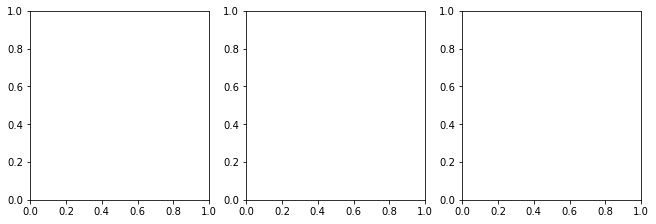

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (9,3), ncols = 3, constrained_layout = True)

graphs  = datasets["facebook"]["data"]
# pos = nx.spring_layout(graph, iterations=25)

def community_draw(graph, ax, pos):

    communities = lv.best_partition(graph, randomize=True)

    colors = get_colors(communities)



    nx.draw_networkx_nodes(graph,
                           pos = pos,
                           node_size = 25,
                          node_color = colors,
                          ax = ax,
                           cmap = "tab20",
                          edgecolors="0")
    nx.draw_networkx_edges(graph, pos = pos, ax = ax)
    
    
    ax.set_title(r"$|V| = {{{}}}, {{{}}}$ communities".format(len(colors), np.unique(colors).shape[0]))
    
    return ax

ax1 = community_draw(graphs[0], ax1, nx.spring_layout(graphs[0], iterations=25))
ax2 = community_draw(graphs[4], ax2, nx.spring_layout(graphs[4], iterations=25))
ax3 = community_draw(graphs[5], ax3, nx.spring_layout(graphs[5], iterations=25))

plt.savefig("Community_example.jpg", dpi = 300)
plt.show()